In [8]:
import pandas as pd
#Carga de datos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";", encoding='utf-8')

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022 (3).csv


/tmp/ipython-input-8-2125804881.py:7: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, sep=";", encoding='utf-8')


/tmp/ipython-input-9-4210024141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})


RoundWinner
0    39588
1    39568
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      1498
           1       0.65      0.68      0.67      1502

    accuracy                           0.66      3000
   macro avg       0.66      0.66      0.66      3000
weighted avg       0.66      0.66      0.66      3000



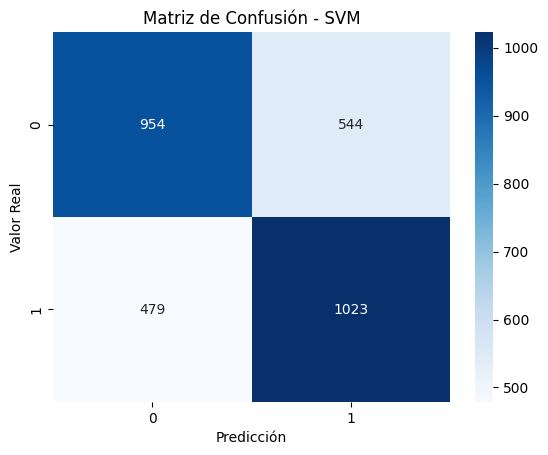

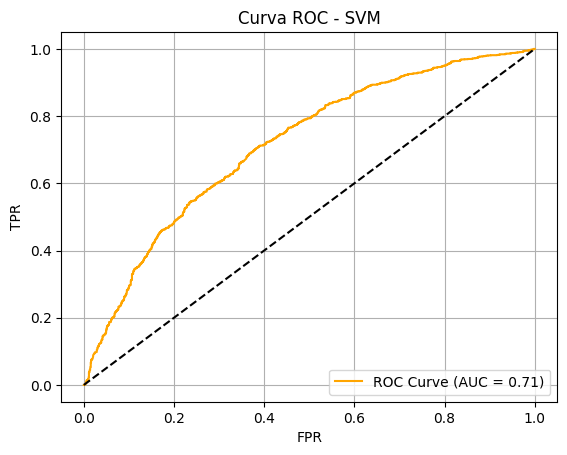

In [9]:
# Filtrar registros válidos y limpiar RoundWinner
df = df.copy()
df['RoundWinner'] = df['RoundWinner'].astype(str).str.strip()
df = df[df['RoundWinner'].isin(['True', 'False'])]
df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})
df = df[df['AbnormalMatch'] == False]

# Crear variables
df['MatchImpact'] = df['MatchKills'] + df['MatchAssists'] + df['MatchHeadshots']
df['RoundEfficiency'] = df['RoundKills'] / (df['RoundStartingEquipmentValue'] + 1)
df['KillAssistRatio'] = (df['RoundKills'] + df['RoundAssists']) / (df['RoundKills'] + 1)
df['HeadshotRate'] = df['RoundHeadshots'] / (df['RoundKills'] + 1)
df['GrenadeTotal'] = df['RLethalGrenadesThrown'] + df['RNonLethalGrenadesThrown']
df['GrenadesPerKill'] = df['GrenadeTotal'] / (df['RoundKills'] + 1)
df['ValuePerKill'] = df['RoundStartingEquipmentValue'] / (df['RoundKills'] + 1)

# Variables y target
features = [
    'MatchImpact', 'RoundEfficiency', 'KillAssistRatio', 'HeadshotRate',
    'GrenadesPerKill', 'ValuePerKill',
    'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown',
    'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy',
    'PrimarySMG', 'PrimaryPistol',
    'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
    'RoundStartingEquipmentValue', 'MatchKills', 'MatchFlankKills',
    'MatchAssists', 'MatchHeadshots'
]

df_modelo = df[features + ['RoundWinner']].dropna()

# Revisar que RoundWinner tenga valores 0 y 1
print(df_modelo['RoundWinner'].value_counts())

# Reducción y separación con 15000 muestras
from sklearn.utils import resample
df_muestra = resample(df_modelo, n_samples=15000, random_state=42)

X = df_muestra[features]
y = df_muestra['RoundWinner']

# Escalar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ------------------ ENTRENAMIENTO SVM ------------------
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

modelo_svm = SVC(kernel='linear', probability=True, random_state=42)
modelo_svm.fit(X_train, y_train)

# ------------------ PREDICCIÓN ------------------
y_pred_svm = modelo_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

# Matriz de confusión
matriz_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(matriz_svm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Curva ROC
y_prob_svm = modelo_svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="orange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
